In [5]:
import mlflow
import mlflow.prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot
import optuna

from mlflow_prophet_lab.config import AppConfig, load_config
from mlflow_prophet_lab.data_loader import load_data, RateRecord
from mlflow_prophet_lab.holidays import get_holidays
from mlflow_prophet_lab.weekends_remover import remove_weekends
from mlflow_prophet_lab.cross_validation import run_cross_validation

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [3]:
config: AppConfig = load_config()
mlflow.set_tracking_uri(config.db_uri)

loading config...
config loaded


In [4]:
records: list[RateRecord] = load_data(config)

In [7]:
df = pd.DataFrame([{"ds": r.date, "y": r.rate} for r in records])

In [ ]:
mlflow.set_experiment("first-prophet")

with mlflow.start_run():
    model = Prophet(
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10,
        yearly_seasonality=True,
        weekly_seasonality=True,
    )
    model.fit(df)

    mlflow.log_params(
        {
            "changepoint_prior_scale": 0.05,
            "seasonality_prior_scale": 10,
            "yearly_seasonality": True,
            "weekly_seasonality": True,
        }
    )

    cv_results = cross_validation(
        model,
        initial="730 days",
        period="180 days",
        horizon="365 days",
    )

    metrics = performance_metrics(cv_results)
    mlflow.log_metrics(metrics[["mse", "rmse", "mae", "mape"]].mean().to_dict())

    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)

    fig_components = model.plot_components(forecast)
    mlflow.log_figure(fig_components, "forecast_components.png")

    fig_forecast = model.plot(forecast)
    mlflow.log_figure(fig_forecast, "forecast_plot.png")

    mlflow.prophet.log_model(
        pr_model=model, name="prophet_model", input_example=df[["ds"]].head()
    )

18:47:12 - cmdstanpy - INFO - Chain [1] start processing
18:47:14 - cmdstanpy - INFO - Chain [1] done processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:23 - cmdstanpy - INFO - Chain [1] done processing
18:47:23 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:26 - cmdstanpy - INFO - Chain

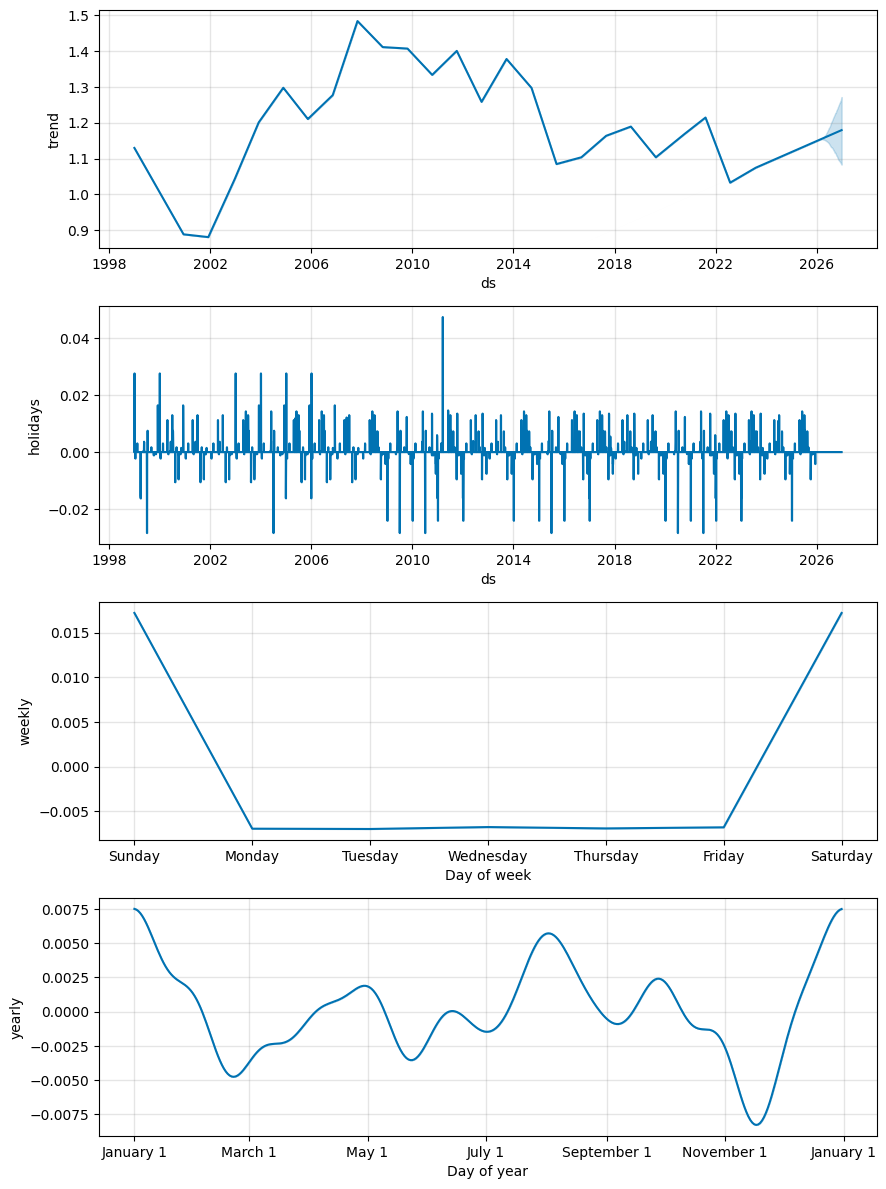

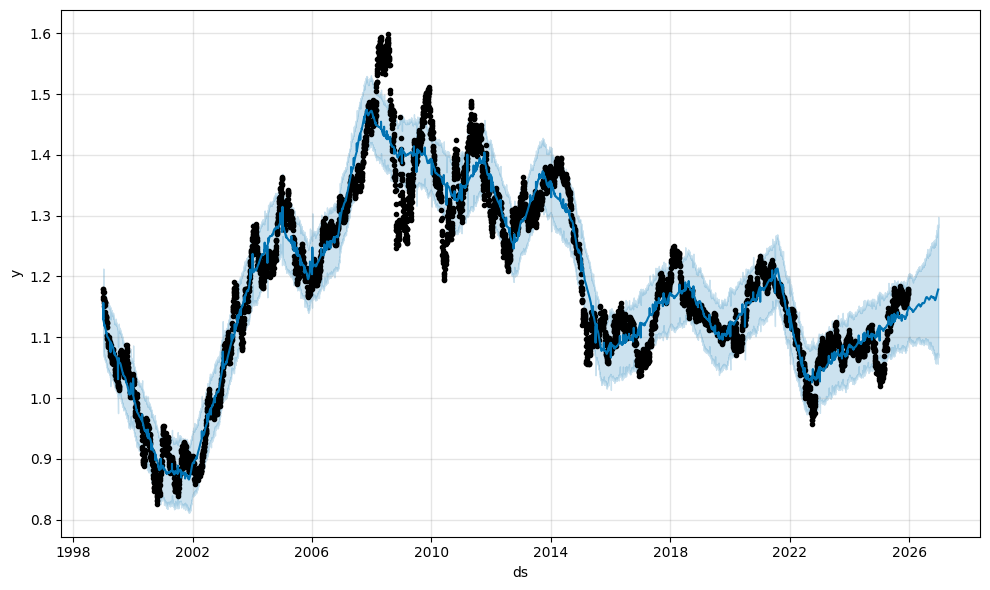

In [23]:
mlflow.set_experiment("after_hpo")

with mlflow.start_run():
    changepoint_prior_scale = 0.12100561409889186
    changepoint_range = 0.91
    seasonality_prior_scale = 1.910812004945756
    holidays_prior_scale = 3.1092302068152957
    yearly_seasonality = 12.662262647981809
    seasonality_mode = "additive"
    years = list(range(df["ds"].min().year, df["ds"].max().year + 1))
    
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        yearly_seasonality=yearly_seasonality,
        seasonality_mode=seasonality_mode,
        holidays=get_holidays(years),
    )
    model.fit(df)
    
    mlflow.log_params(
        {
            "changepoint_prior_scale": changepoint_prior_scale,
            "changepoint_range": changepoint_range,
            "seasonality_prior_scale": seasonality_prior_scale,
            "holidays_prior_scale": holidays_prior_scale,
            "yearly_seasonality": yearly_seasonality,
            "seasonality_mode": seasonality_mode,
        }
    )
    cv_results = run_cross_validation(model)
    metrics = performance_metrics(cv_results)
    mlflow.log_metrics(metrics[["mse", "rmse", "mae", "mape"]].mean().to_dict())

    future = model.make_future_dataframe(periods=365, include_history=True)
    future = remove_weekends(future)
    forecast = model.predict(future)

    fig_components = model.plot_components(forecast)
    mlflow.log_figure(fig_components, "forecast_components.png")

    fig_forecast = model.plot(forecast)
    mlflow.log_figure(fig_forecast, "forecast_plot.png")

    mlflow.prophet.log_model(
        pr_model=model, name="prophet_model", input_example=df[["ds"]].head()
    )